Here our goal is to predict ratings of games of on Steam (a video game digital distribution service) based on the data from Kaggle.<br>
(https://www.kaggle.com/datasets/whigmalwhim/steam-releases)<br>
This is done is steps below:

1. Undestanding the data
2. Transformaing the data into usable form for the data
3. Further feature engineering for our model (tree based models)
4. Modeling and prediction

We start by importing libraries necessary for our task.

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import Series, DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost  as xgb
import statsmodels.api as sm
import pylab
from scipy.stats import yeojohnson
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from datetime import datetime
import re
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm
from mlxtend.regressor import StackingCVRegressor

## Understanding the Data

In [2]:
# importing Data
df = pd.read_csv('/Users/wootaekkim/Desktop/youtube learning/games-release-ALL.csv')
df.head()

,Unnamed: 0,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating
0,0,Pizza Tower,/app/2231450/,Jan 26 2023,"4,529","19,807",227,227,96.39%
1,1,Resident Evil 4,/app/2050650/,Mar 24 2023,"168,191","61,752","1,616","1,616",95.75%
2,2,The Murder of Sonic the Hedgehog,/app/2324650/,Mar 31 2023,"15,543","12,643",213,213,95.54%
3,3,Pineapple on pizza,/app/2263010/,Mar 28 2023,"1,415","11,717",209,209,95.39%
4,4,Hi-Fi RUSH,/app/1817230/,Jan 25 2023,"6,132","14,152",324,324,95.09%


In [3]:
df.tail()

,Unnamed: 0,game,link,release,peak_players,positive_reviews,negative_reviews,total_reviews,rating
66422,66422,Space Empires V,/app/1690/,Oct 16 2006,137,290,120,120,67.34%
66423,66423,Iron Warriors: T-72 Tank Command,/app/1670/,Jul 26 2006,15,173,104,104,60.17%
66424,66424,Gumboy: Crazy Adventures,/app/2520/,Dec 19 2006,22,61,60,60,50.32%
66425,66425,Shattered Union,/app/3960/,Oct 25 2006,13,71,70,70,50.27%
66426,66426,Poker Superstars II,/app/4100/,Oct 5 2006,9,6,7,7,47.89%


In [4]:
# check column names of the data
df.columns

Index(['Unnamed: 0', 'game', 'link', 'release', 'peak_players',
       'positive_reviews', 'negative_reviews', 'total_reviews', 'rating'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66427 entries, 0 to 66426
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        66427 non-null  int64 
 1   game              66427 non-null  object
 2   link              66427 non-null  object
 3   release           66427 non-null  object
 4   peak_players      66427 non-null  object
 5   positive_reviews  66427 non-null  object
 6   negative_reviews  66427 non-null  object
 7   total_reviews     66427 non-null  object
 8   rating            66427 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.6+ MB


First eliminate Unnamesd:0, game, and link since they are unnecessary for the prediction of the ratings. Then we also have to change some columns into numeric such as peak_playeras, positive_reviews, negative_reviews, total_reviews, ratings.<br>
Here good thing is that we do not have any missing or null values

In [6]:
df.drop(['Unnamed: 0','game', 'link'], axis = 1, inplace = True)
df.columns

Index(['release', 'peak_players', 'positive_reviews', 'negative_reviews',
       'total_reviews', 'rating'],
      dtype='object')

## Feature Engineering

### From Strings to Numerical values

In [7]:
def only_number(x):
    return re.findall('[0-9]{2}[\.]{1}[0-9]{2}', x)[0]

In [8]:
# test that out function works
only_number('96.39%')

'96.39'

In [9]:
df['rating'] = df['rating'].apply(lambda x: only_number(x))
df['rating'] = df['rating'].apply(pd.to_numeric)
df['rating'].dtypes

dtype('float64')

In [10]:
df['peak_players'] = df['peak_players'].apply(lambda x: x.replace(',', ''))
df['positive_reviews'] = df['positive_reviews'].apply(lambda x: x.replace(',', ''))
df['negative_reviews'] = df['negative_reviews'].apply(lambda x: x.replace(',', ''))
df['total_reviews'] = df['total_reviews'].apply(lambda x: x.replace(',', ''))

df['peak_players'] = df['peak_players'].apply(pd.to_numeric)
df['positive_reviews'] = df['positive_reviews'].apply(pd.to_numeric)
df['negative_reviews'] = df['negative_reviews'].apply(pd.to_numeric)
df['total_reviews'] = df['total_reviews'].apply(pd.to_numeric)
df[['peak_players','positive_reviews','negative_reviews','total_reviews']].head()

,peak_players,positive_reviews,negative_reviews,total_reviews
0,4529,19807,227,227
1,168191,61752,1616,1616
2,15543,12643,213,213
3,1415,11717,209,209
4,6132,14152,324,324


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66427 entries, 0 to 66426
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   release           66427 non-null  object 
 1   peak_players      66427 non-null  int64  
 2   positive_reviews  66427 non-null  int64  
 3   negative_reviews  66427 non-null  int64  
 4   total_reviews     66427 non-null  int64  
 5   rating            66427 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 3.0+ MB


Above we have dealt with variables that contains numeric values as string. Now sperate release column into to three different columns; year, month, date.

In [12]:
df['release'].head()

0    Jan 26 2023
1    Mar 24 2023
2    Mar 31 2023
3    Mar 28 2023
4    Jan 25 2023
Name: release, dtype: object

In [13]:
df['year'] = df['release'].apply(lambda x: int(re.findall('\s([0-9]{4})', x)[0]))
df['date'] = df['release'].apply(lambda x: int(re.findall('\s([0-9]{1,2})\s', x)[0]))
df['month'] = df['release'].apply(lambda x: re.findall('([A-Za-z]{3})\s', x)[0])
df[['year', 'month', 'date']].head()

,year,month,date
0,2023,Jan,26
1,2023,Mar,24
2,2023,Mar,31
3,2023,Mar,28
4,2023,Jan,25


In [14]:
df.drop('release', axis=1, inplace = True)
df.head()

,peak_players,positive_reviews,negative_reviews,total_reviews,rating,year,date,month
0,4529,19807,227,227,96.39,2023,26,Jan
1,168191,61752,1616,1616,95.75,2023,24,Mar
2,15543,12643,213,213,95.54,2023,31,Mar
3,1415,11717,209,209,95.39,2023,28,Mar
4,6132,14152,324,324,95.09,2023,25,Jan


### Understanding relationship between features

Check the correlation matrix to see relations between target and features variable and also correlation between feature variables.

In [15]:
df.corr()

/var/folders/cy/j205pskx0zx83x7sz14l4jhw0000gn/T/ipykernel_25466/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,peak_players,positive_reviews,negative_reviews,total_reviews,rating,year,date
peak_players,1.000000,0.580232,0.814003,0.814003,0.042790,-0.024163,0.000621
positive_reviews,0.580232,1.000000,0.790110,0.790110,0.062124,-0.043239,0.000764
negative_reviews,0.814003,0.790110,1.000000,1.000000,0.025954,-0.031058,0.000828
total_reviews,0.814003,0.790110,1.000000,1.000000,0.025954,-0.031058,0.000828
rating,0.042790,0.062124,0.025954,0.025954,1.000000,-0.004013,0.005977
year,-0.024163,-0.043239,-0.031058,-0.031058,-0.004013,1.000000,-0.004141
date,0.000621,0.000764,0.000828,0.000828,0.005977,-0.004141,1.000000


/var/folders/cy/j205pskx0zx83x7sz14l4jhw0000gn/T/ipykernel_25466/2605090071.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

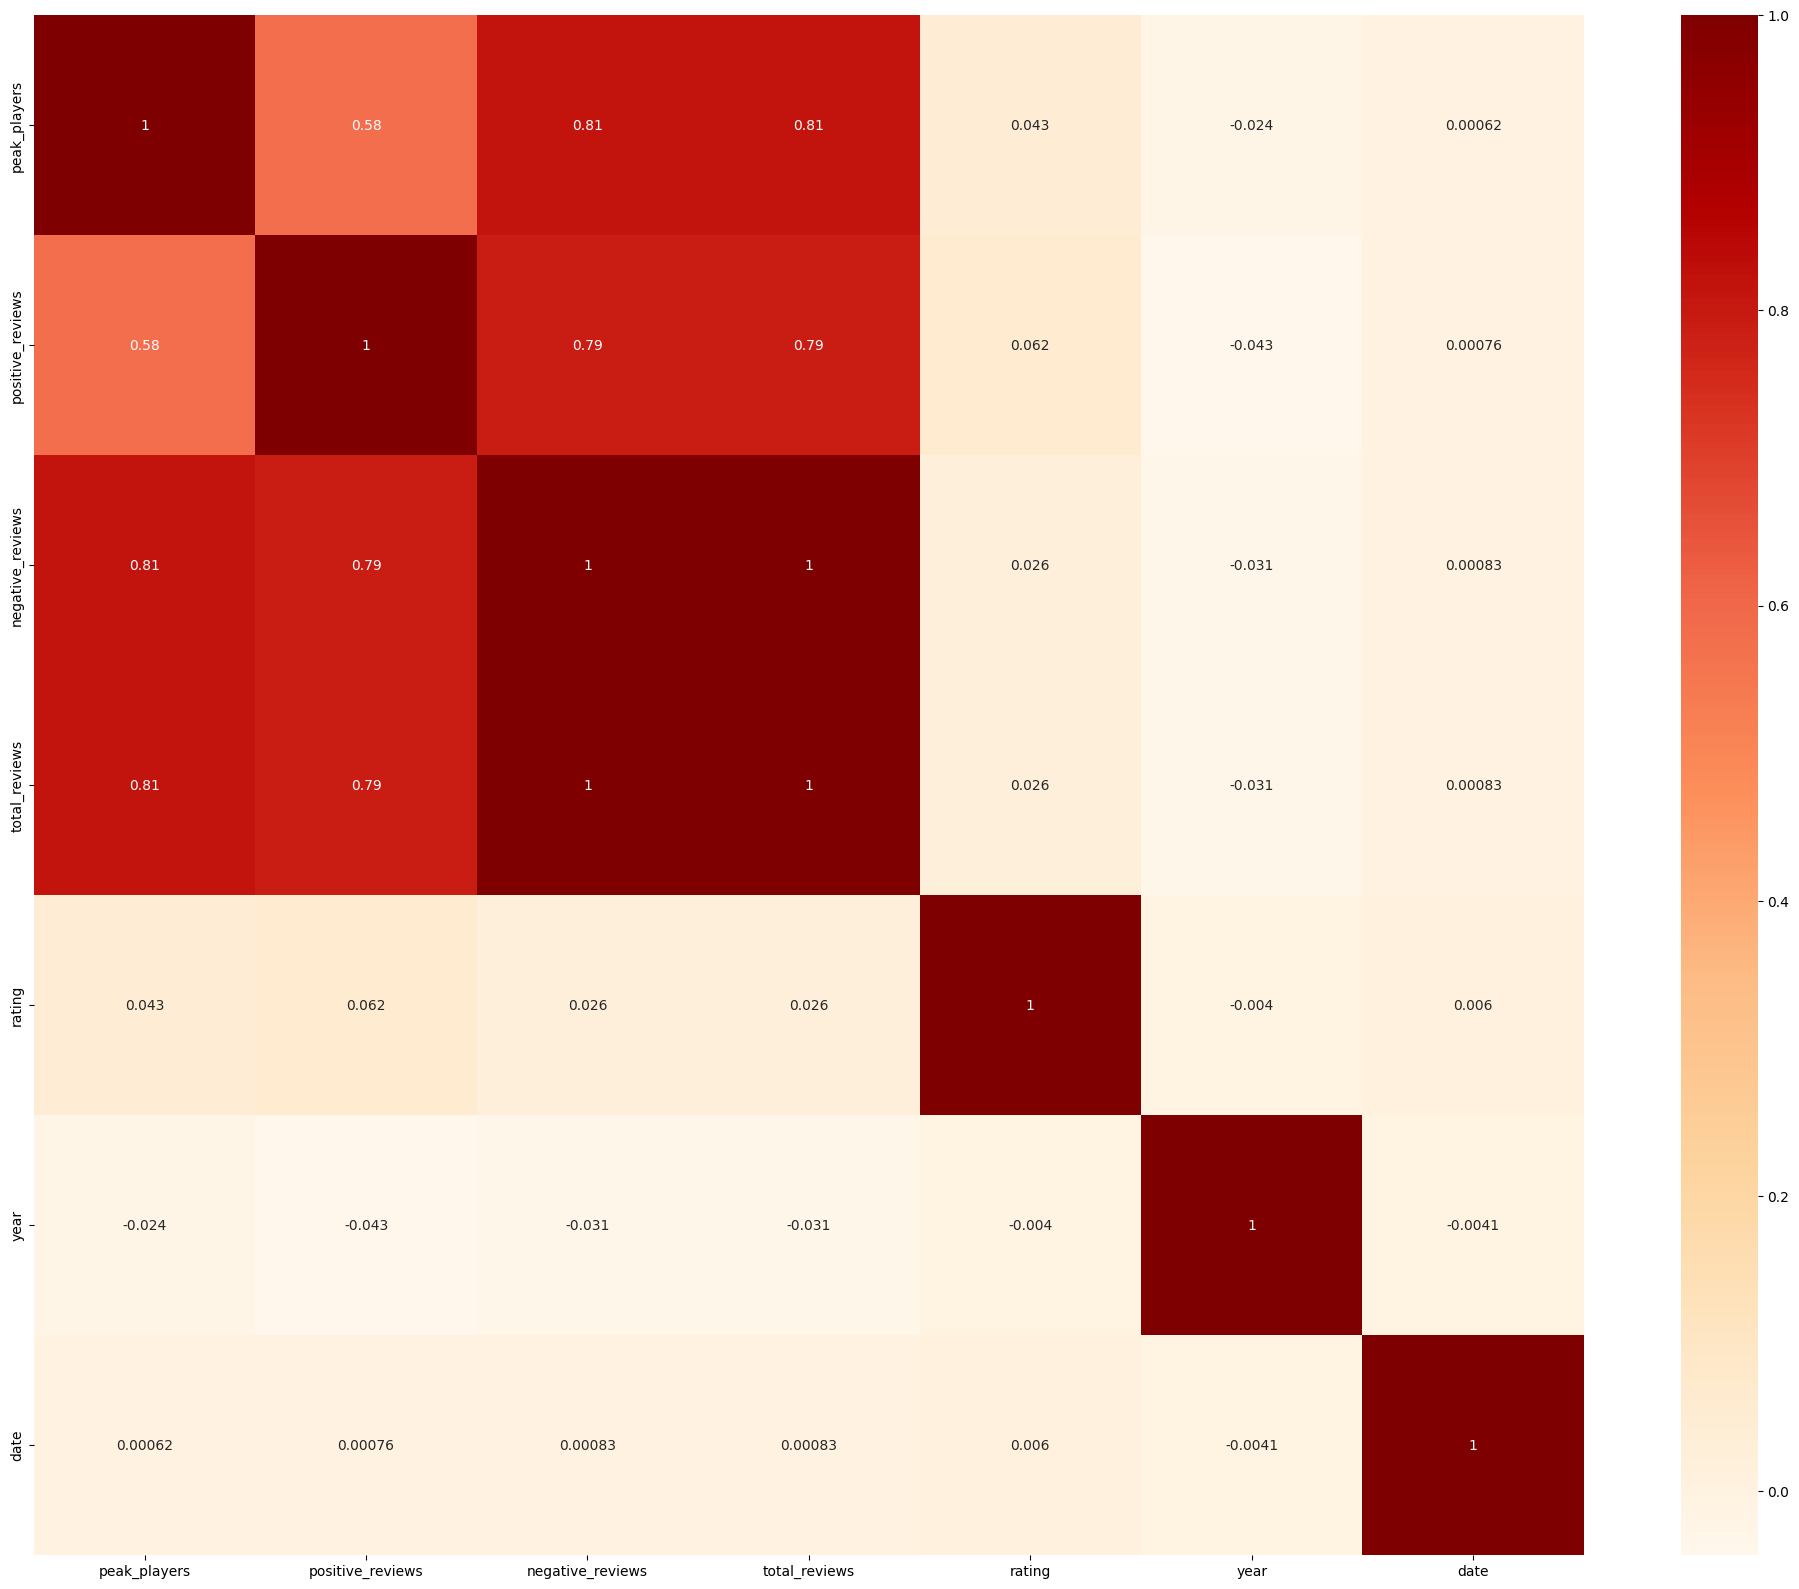

In [16]:
corr = df.corr()
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True, cmap = 'OrRd')

From above, we can see that 'positive reviews', 'negative reviews', and 'total reviews' are highly correlated. So, remove 'positive reviews' and 'negative reviews' and replace them with 'positive_neagtive_ratio'.

In [17]:
df[['positive_reviews', 'negative_reviews']].describe()

,positive_reviews,negative_reviews
count,6.642700e+04,66427.000000
mean,1.288212e+03,219.139356
std,2.979934e+04,5480.988838
min,0.000000e+00,0.000000
25%,5.000000e+00,1.000000
50%,1.900000e+01,6.000000
75%,1.000000e+02,29.000000
max,6.307931e+06,927317.000000


### Transforming features

Remove positive ratings, negative rating and total reviews and keep positive and negative ratings ratio. 

In [18]:
# add one because there are 0 in negative reviews which can possibly give us 
# not a number value.
df['positive_negative_ratio'] = (df['positive_reviews']+1)/(df['negative_reviews']+1)
df.drop(['positive_reviews', 'negative_reviews'], axis = 1, inplace = True)

From above, we could see that correlation coefficient between peak players and total reviews is very high. The reason I did not remove it is because after I removed this feature and trained it, this significantly worsen the performance of the model (which are tree based models such as LightGBM, XGBoost).<br>
<br>
There are two possible reasons for this. One is because peak players is one the major feature that has relatively high correlation coefficient with our target (rating). Consequently, removing it could reduce tree's ability to differentiate between data. Another possible reason is that tree does get hugely influenced by the correlation between features.<br>
<br>
However, if we were to use models such as lasso, ridge regression models, one of peak players or total reviews should be removed to increase the performance of the model

/var/folders/cy/j205pskx0zx83x7sz14l4jhw0000gn/T/ipykernel_25466/2605090071.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

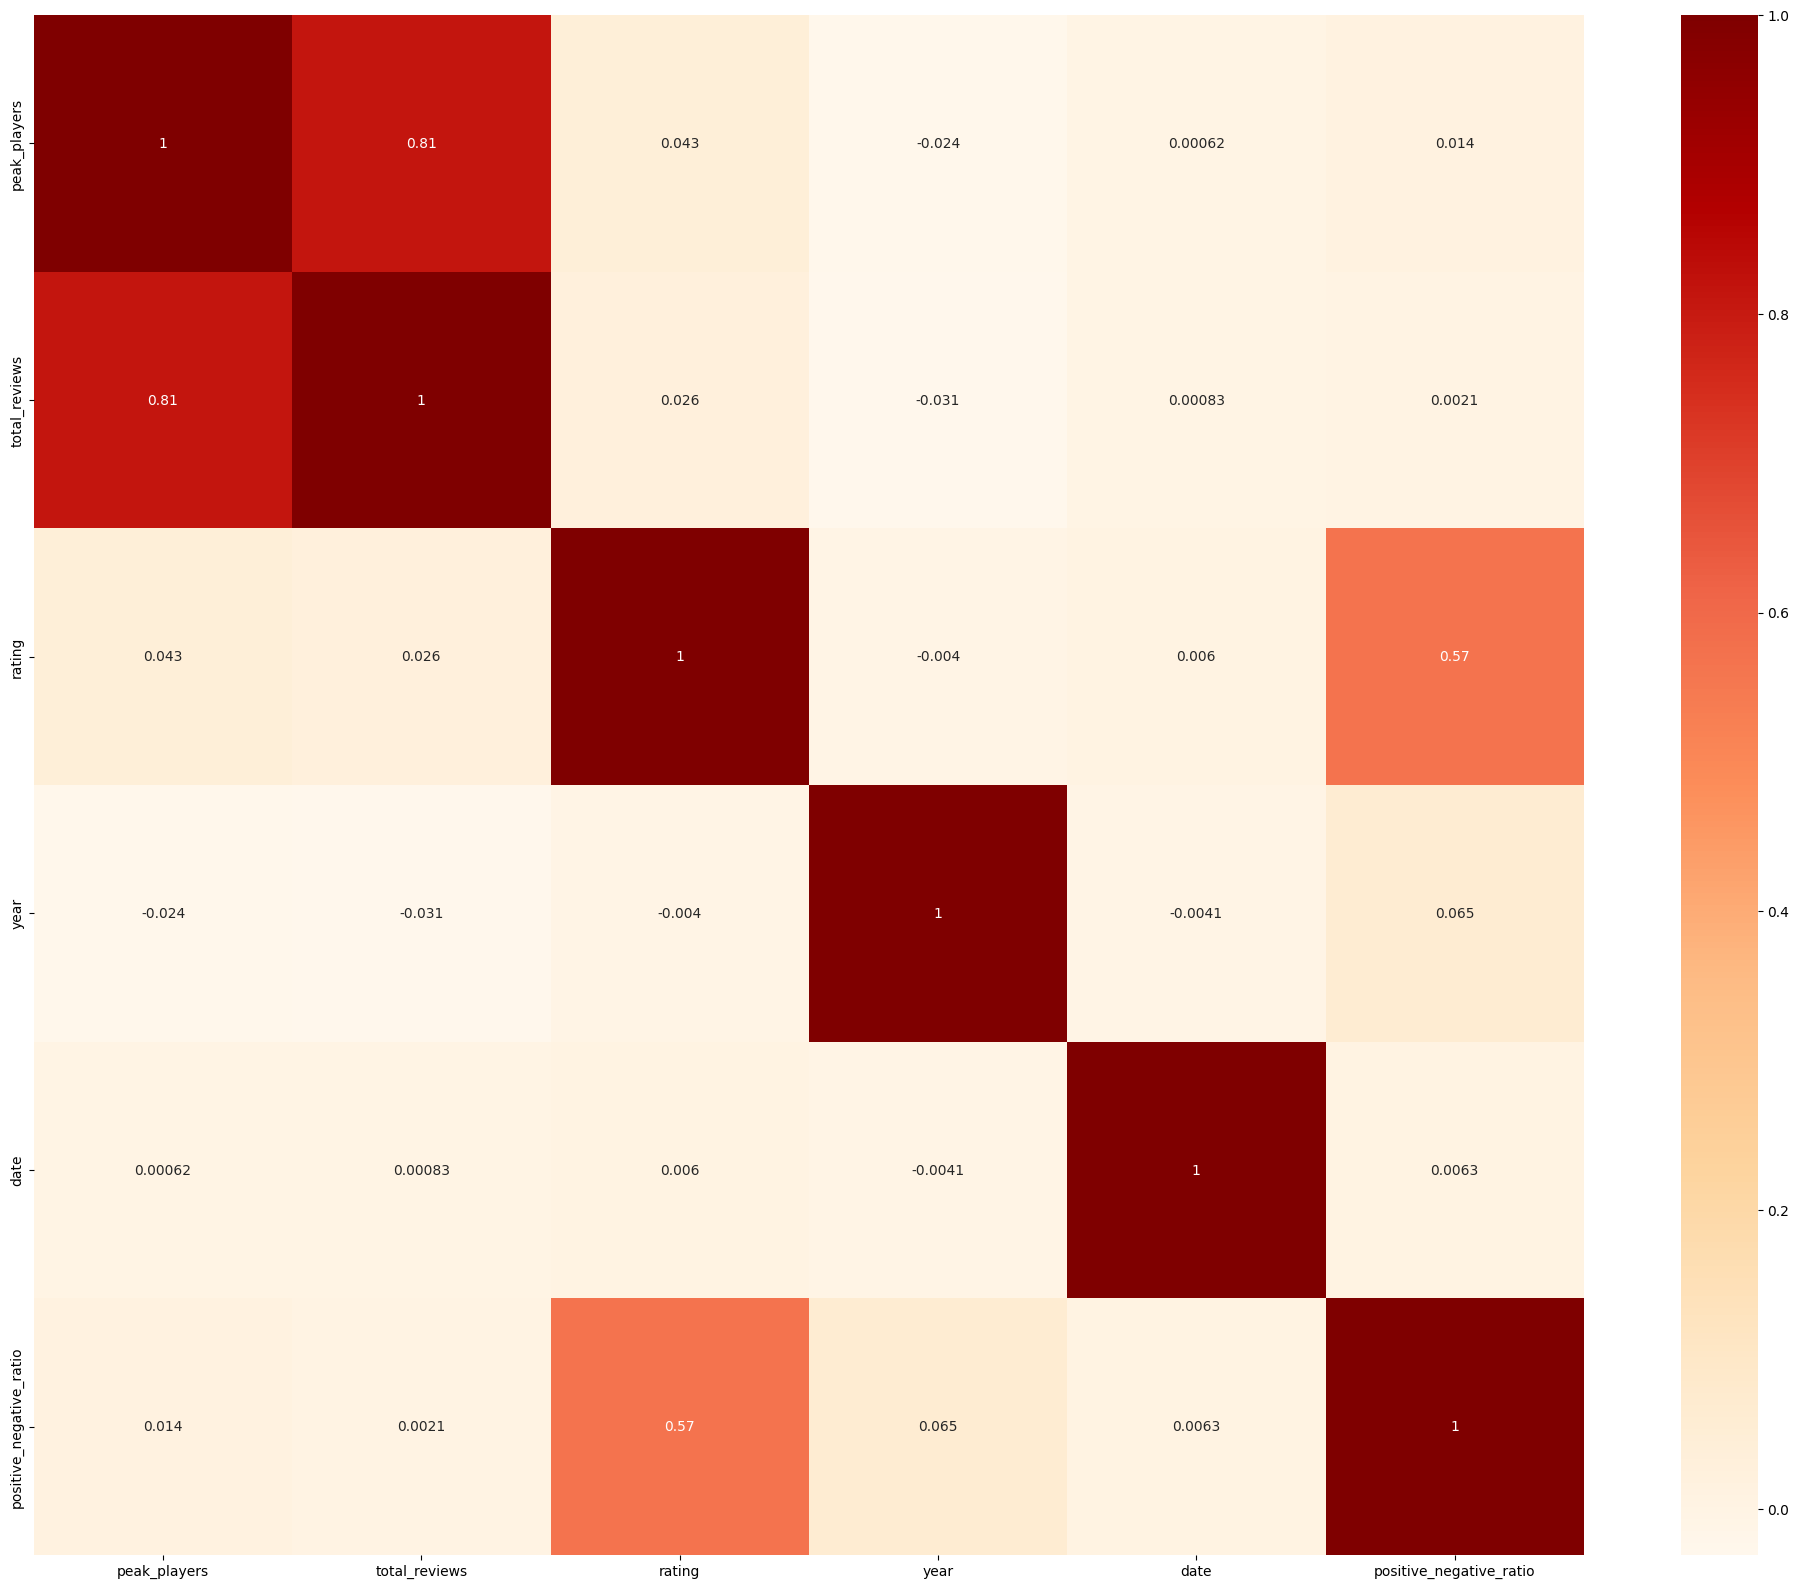

In [19]:
corr = df.corr()
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True, cmap = 'OrRd')

Now take a look at types, unique values and disributions of our variables after transformations above

In [20]:
numeric = ['int64', 'float64']
not_numeric = ['object']
quantitative = []
qualitative = []
for col in df.columns:
    if df[col].dtype in numeric:
        quantitative.append(df[col].name)
    elif df[col].dtype in not_numeric:
        qualitative.append(df[col].name)

In [21]:
#check the unique values again for numeric and categorical variables
for col in quantitative:
    print('number of unique values of',col, ": " ,len(df[col].unique()))
    print(' ')
    print('unique values: ', df[col].unique())
    print('_____________________________________________________________')

number of unique values of peak_players :  4160
 
unique values:  [  4529 168191  15543 ...   4600   3811   9960]
_____________________________________________________________
number of unique values of total_reviews :  2330
 
unique values:  [ 227 1616  213 ...  557  741  837]
_____________________________________________________________
number of unique values of rating :  5688
 
unique values:  [96.39 95.75 95.54 ... 27.23 95.93 50.27]
_____________________________________________________________
number of unique values of year :  18
 
unique values:  [2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010
 2009 2008 2007 2006]
_____________________________________________________________
number of unique values of date :  31
 
unique values:  [26 24 31 28 25  9  1 19 13 11  3 12 14 27 30  2 20 10 17  8  6 21  4 18
 29 15 23  7 22 16  5]
_____________________________________________________________
number of unique values of positive_negative_ratio :  15635
 
unique v

In [22]:
for col in qualitative:
    print('number of unique values of',col, ": " ,len(df[col].unique()))
    print(' ')
    print('unique values: ', df[col].unique())
    print('_____________________________________________________________')

number of unique values of month :  12
 
unique values:  ['Jan' 'Mar' 'Apr' 'Feb' 'Dec' 'Jun' 'Oct' 'Jul' 'Aug' 'Sep' 'Nov' 'May']
_____________________________________________________________


Now look at the distribution plots of all the numerical variables

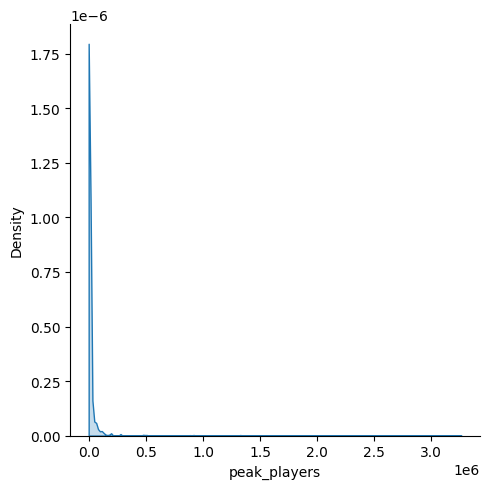

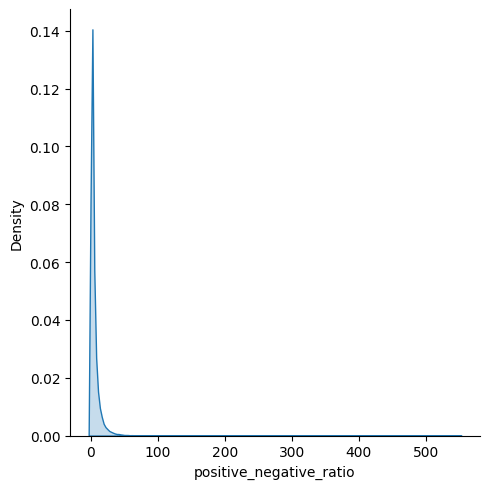

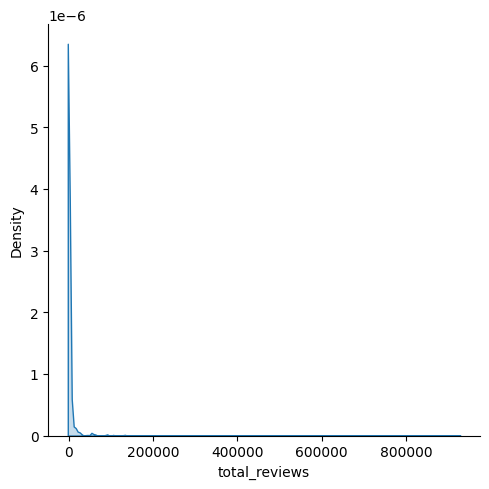

In [23]:
sns.displot(data = df, x='peak_players' , kind="kde", fill=True)
sns.displot(data = df, x='positive_negative_ratio' , kind="kde", fill=True)
sns.displot(data = df, x='total_reviews' , kind="kde", fill=True)
plt.show()                                       

We can see that all the numerical variables are highly right skewes except ratings which is our target. So, use boxcox to make transformation on our numerical features

In [24]:
numeric_feature = ['peak_players', 'positive_negative_ratio', 'total_reviews']
for col in numeric_feature:
    df[col] = boxcox1p(df[col], 
                    boxcox_normmax(df[col]+1))

<Figure size 2000x1500 with 0 Axes>

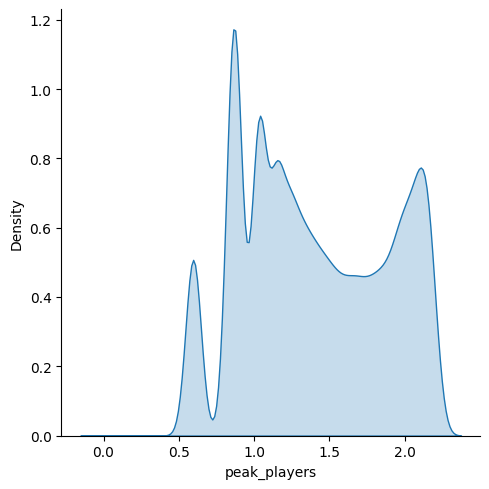

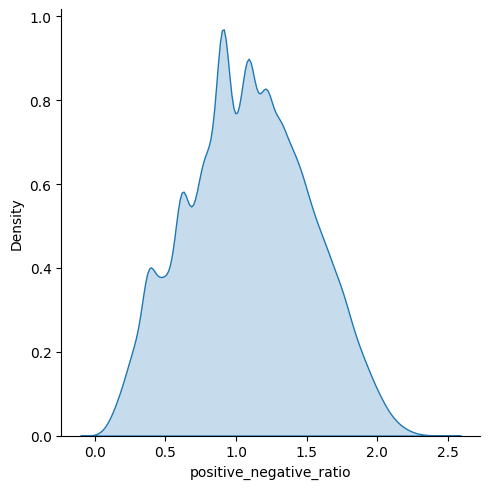

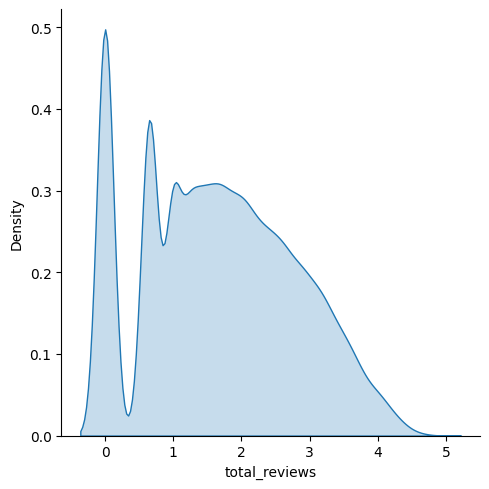

In [25]:
fig = plt.figure(figsize = (20,15))
for i in range(len(numeric_feature)):
    sns.displot(df, x=numeric_feature[i] , kind="kde", fill=True)

In [26]:
# Have to figure out transformation for total reviews and peak players to normalize the
# distribution before fitting into the model

# reciprocal doesn't work
# yeojohnson doesn't work
# Therefore, as above is as close as possible we can get to normal distribution,
# just use boxcox transformation to our numerical features

Above we have looked and transformed numerical features. Now we explore and transform our target variable, ratings

In [28]:
df.columns

Index(['peak_players', 'total_reviews', 'rating', 'year', 'date', 'month',
       'positive_negative_ratio'],
      dtype='object')

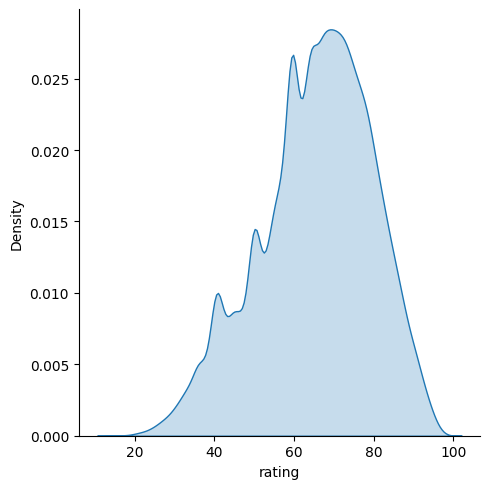

In [29]:
sns.displot(df, x=df['rating'] , kind="kde", fill=True)

From above we can see that there is no need to transform our target variable

Now we have transformed our numeric features, now deal with date, month, and year featrure. 

### Dealing with dates, months, year

first change month to numerical variable and check correlation with the target(ratings)

In [30]:
convert_months = {'Jan':1, 'Mar':3, 'Apr':4, 'Feb':2, 'Dec':12, 'Jun':6, 'Oct':10,
                 'Jul':7, 'Aug':8, 'Sep':9, 'Nov':9, 'May':5}
df.replace({'month':convert_months} , inplace =True)
df.head()       

,peak_players,total_reviews,rating,year,date,month,positive_negative_ratio
0,2.171074,3.379373,96.39,2023,26,1,2.196061
1,2.211406,3.958667,95.75,2023,24,3,2.014541
2,2.192455,3.356773,95.54,2023,31,3,2.117277
3,2.136543,3.349991,95.39,2023,28,3,2.104667
4,2.177474,3.500870,95.09,2023,25,1,2.047059


<AxesSubplot: >

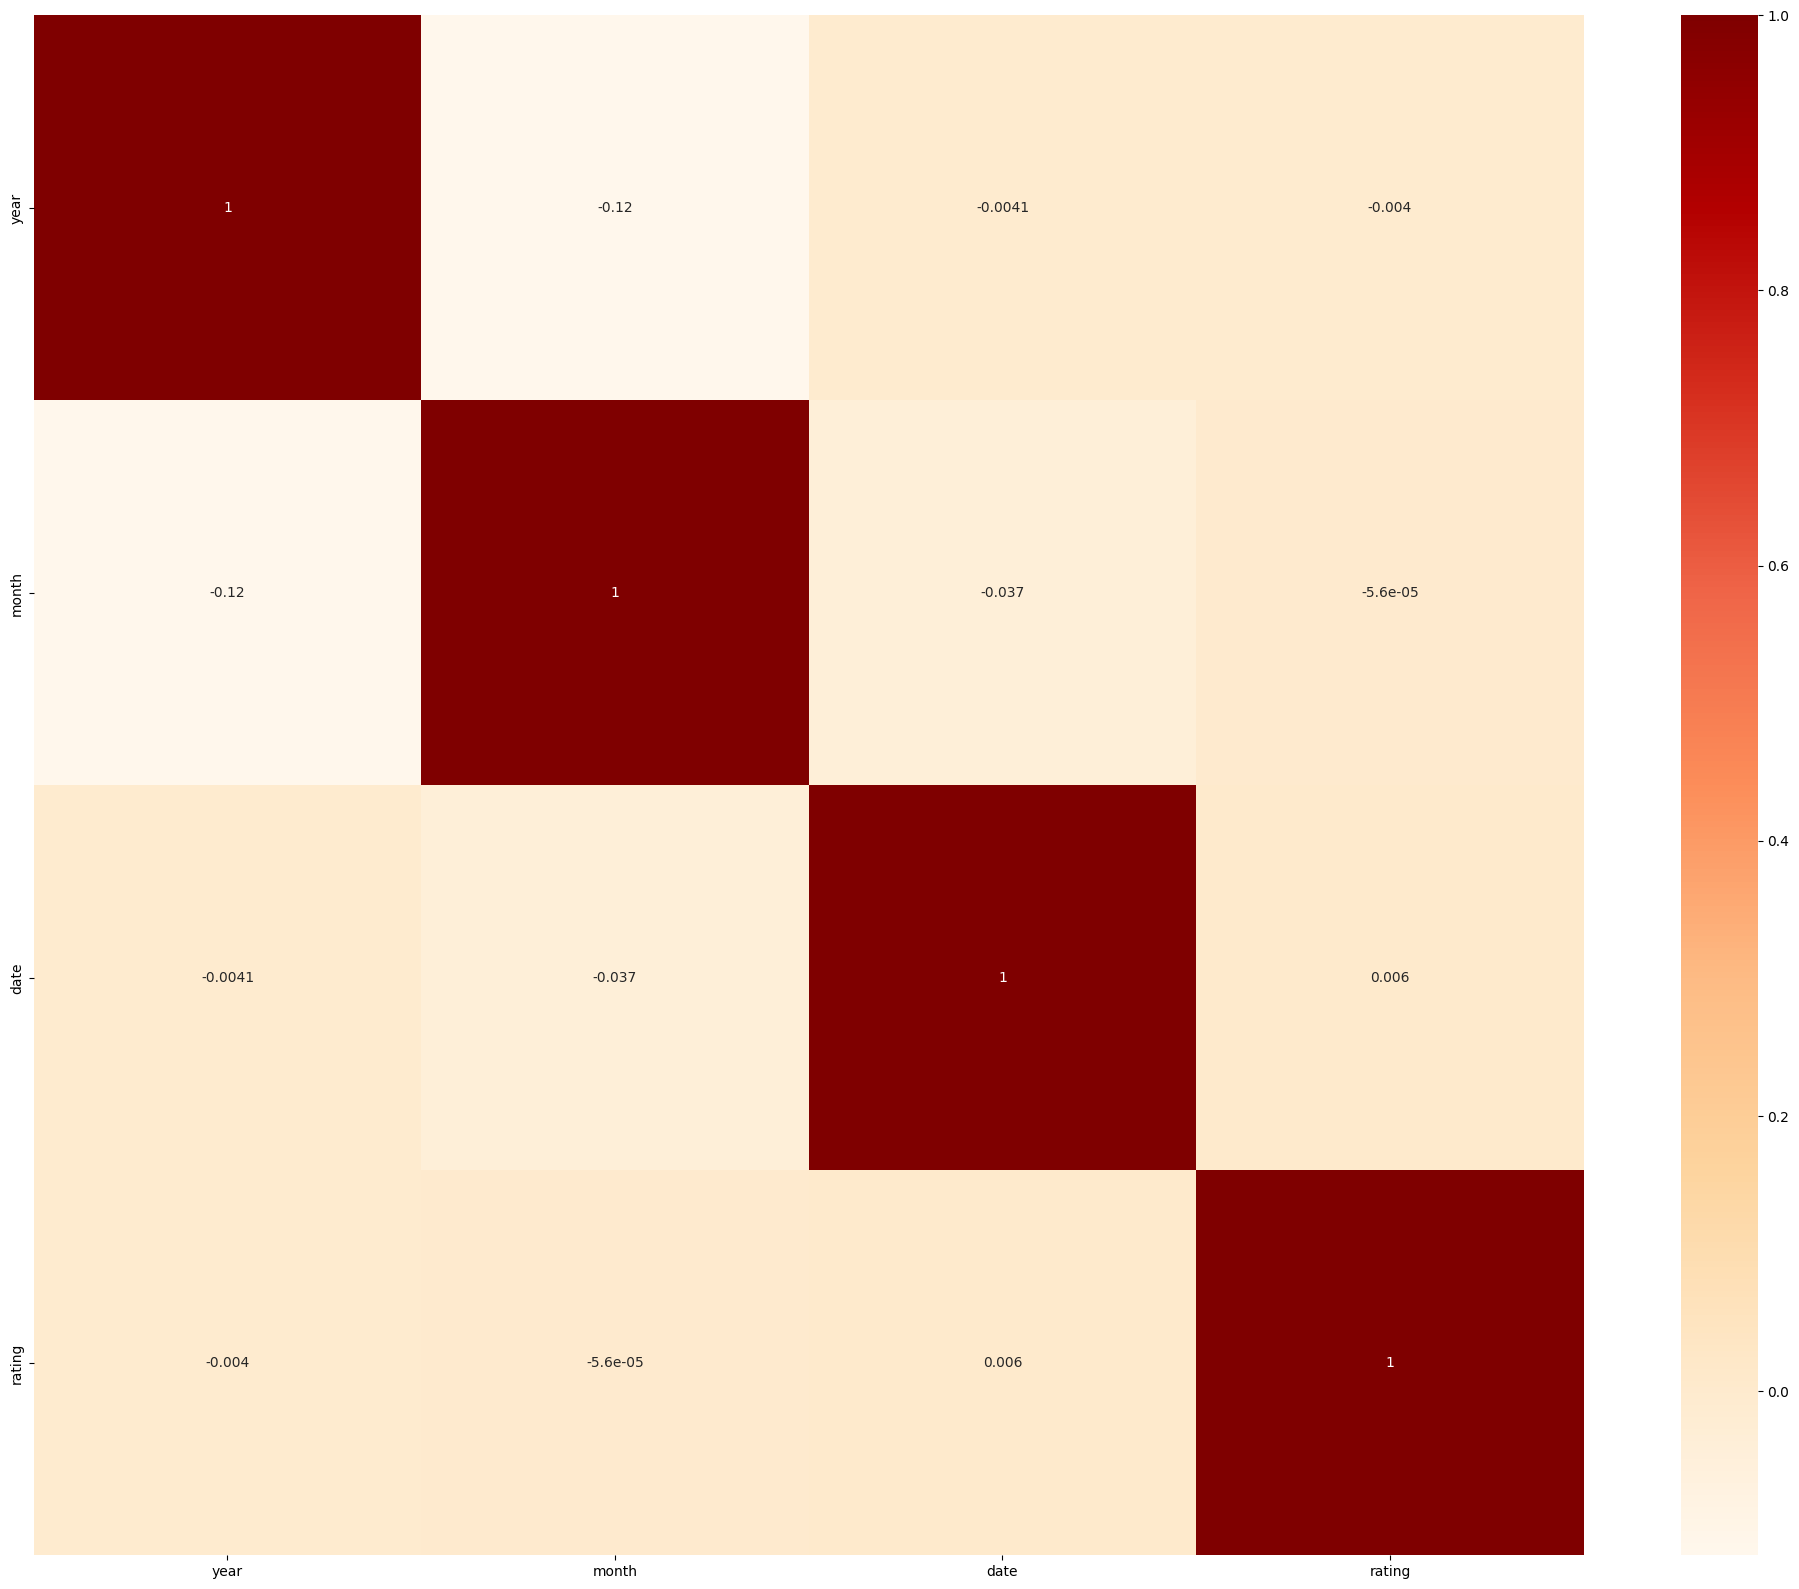

In [31]:
corr = df[['year', 'month', 'date', 'rating']].corr()
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True, cmap = 'OrRd')

We can see from above that all the variables related to time are very weakly correlated to ratings. So except for the year, drop all the variables and make year into dummy variables.<br>
We make them into dummy variables since we are going to be using tree based models such as XGBoost and LightGBM.

In [32]:
df.drop(['month', 'date'], axis = 1, inplace =True)

In [33]:
df['year'] = df['year'].apply(lambda x: str(x))
final_df = pd.get_dummies(df)
final_df.head()

,peak_players,total_reviews,rating,positive_negative_ratio,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023
0,2.171074,3.379373,96.39,2.196061,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.211406,3.958667,95.75,2.014541,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.192455,3.356773,95.54,2.117277,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.136543,3.349991,95.39,2.104667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2.177474,3.500870,95.09,2.047059,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
final_df.shape

(66427, 22)

## Modeling

From above, we have seen that some features are not normally distributed even after transformations. so use tree based model instead. Here we are going to use XGBoost and LightGBM

Before getting into modeling, split X and y. Then also split between training and testing set

In [35]:
X = final_df.drop('rating', axis = 1)
y = final_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [36]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### XGBoost

Use RandomizedSearchCV to find best hyperparameter for fitting XGBoost.<br>
The reason here us because we relatively have large number of data so that it would take too long if we use GridSearchCV as it tries every single possible combinations.

In [40]:
reg_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42)

params_1 = {'nthread':[3,4,5], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.01, 0.03, 0.05], #so called `eta` value
              'max_depth': [3,5,6],
              'reg_lambda': [1, 0, 0.1]}

In [41]:
rand_search1 =RandomizedSearchCV(
    reg_xgb,
    params_1,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.05],
                                        'max_depth': [3, 5, 6],
                                        'nthread': [3, 4, 5],
                                        'reg_lambda': [1, 0, 0.1]},
                   verbose=1)

In [42]:
rand_search1.best_params_

{'reg_lambda': 0.1, 'nthread': 4, 'max_depth': 5, 'learning_rate': 0.05}

In [43]:
params_2 = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.04,0.05, 0.06], #so called `eta` value
              'max_depth': [5],
              'reg_lambda': [0.1, 0.5, 0.05],}

In [44]:
rand_search2 =RandomizedSearchCV(
    reg_xgb,
    params_2,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search2.fit(X_train, y_train)

/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_jobs=10,
                   param_distributions={'learning_rate': [0.04, 0.05, 0.06],
                                        'max_depth': [5], 'nthread': [4],
                                        'reg_lambda': [0.1, 0.5, 0.05]},
                   verbose=1)

In [45]:
rand_search2.best_params_

{'reg_lambda': 0.5, 'nthread': 4, 'max_depth': 5, 'learning_rate': 0.06}

In [46]:
params_3 = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.06, 0.07, 0.08], #so called `eta` value
              'max_depth': [5],
              'reg_lambda': [0.5]}

Since we only have 3 hyperparameters to compare, we use GridSeachCV instead.

In [47]:
grid_search3 = GridSearchCV(
    reg_xgb,
    params_3,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
grid_search3.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.06, 0.07, 0.08], 'max_depth': [5],
                         'nthread': [4], 'reg_lambda': [0.5]},
             verbose=1)

In [48]:
grid_search3.best_params_

{'learning_rate': 0.08, 'max_depth': 5, 'nthread': 4, 'reg_lambda': 0.5}

In [49]:
# train XGBoost model using new hyperparameters from above
reg_xgb_new = xgb.XGBRegressor(objective = 'reg:squarederror',
                              nthread = 4,
                              reg_lambda = 0.5,
                              max_depth = 5,
                              learning_rate = 0.08)
reg_xgb_new.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
             predictor=None, ...)

In [113]:
print('Mean squared error score is:', mean_squared_error(y_test,reg_xgb_new.predict(X_test)))
print('RMSE score is : ', rmse(reg_xgb_new.predict(X_test),y_test))

Mean squared error score is: 0.04226301277308594
RMSE score is :  0.20557969932142117


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

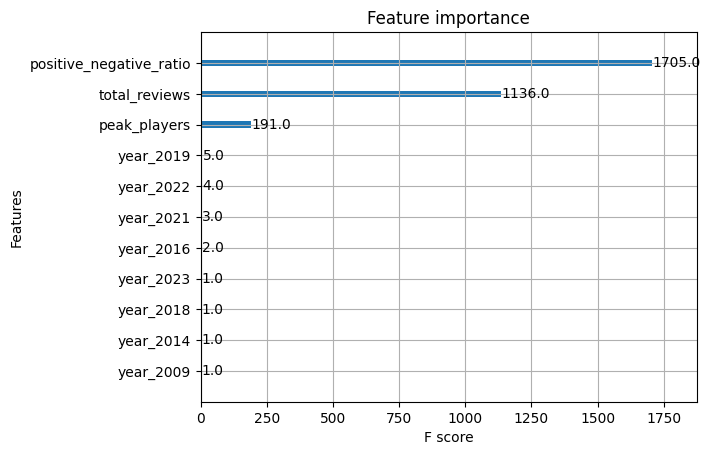

In [52]:
xgb.plot_importance(reg_xgb_new)

### Lightgbm

Same as above, use RandomizedSearchCV for finding best combination of hyperparameters.

In [55]:
reg_lgbm = LGBMRegressor(objective = 'mean_squared_error', random_state =42)
params_4 = {
    'learning_rate': [0.1,0.01, 0.05],
    'num_leaves': [90,150,200],
    'boosting_type' : ['gbdt'],
    'max_depth' : [5,6,7,8],
    'min_split_gain' : [0.01, 0.1 ,0.05],
    'min_data_in_leaf':[10, 20, 30],
    }

In [56]:
rand_search4 =RandomizedSearchCV(
    reg_lgbm,
    params_4,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='mean_squared_error',
                                           random_state=42),
                   n_jobs=10,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [5, 6, 7, 8],
                                        'min_data_in_leaf': [10, 20, 30],
                                        'min_split_gain': [0.01, 0.1, 0.05],
                                        'num_leaves': [90, 150, 200]},
                   verbose=1)

In [57]:
rand_search4.best_params_

{'num_leaves': 150,
 'min_split_gain': 0.05,
 'min_data_in_leaf': 30,
 'max_depth': 8,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

In [58]:
params_5 = {
    'learning_rate': [0.1],
    'num_leaves': [140, 150, 160],
    'boosting_type' : ['gbdt'],
    'max_depth' : [8, 9, 10, 11],
    'min_split_gain' : [0.05, 0.08, 0.03],
    'min_data_in_leaf':[30, 40, 50],
    }

In [59]:
rand_search5 =RandomizedSearchCV(
    reg_lgbm,
    params_5,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='mean_squared_error',
                                           random_state=42),
                   n_jobs=10,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'learning_rate': [0.1],
                                        'max_depth': [8, 9, 10, 11],
                                        'min_data_in_leaf': [30, 40, 50],
                                        'min_split_gain': [0.05, 0.08, 0.03],
                                        'num_leaves': [140, 150, 160]},
                   verbose=1)

In [60]:
rand_search5.best_params_

{'num_leaves': 160,
 'min_split_gain': 0.03,
 'min_data_in_leaf': 30,
 'max_depth': 11,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

In [ ]:
# tried num_leaves': [170, 180, 160] and got 180
# tried 'max_depth' : [11, 12, 13, 14, 15, 20] and got 15

In [65]:
params_6 = {
    'learning_rate': [0.1],
    'num_leaves': [180, 190, 200],
    'boosting_type' : ['gbdt'],
    'max_depth' : [15, 16, 17],
    'min_split_gain' : [0.03, 0.04, 0.02],
    'min_data_in_leaf':[30],
    }

In [66]:
rand_search6 =RandomizedSearchCV(
    reg_lgbm,
    params_6,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search6.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='mean_squared_error',
                                           random_state=42),
                   n_jobs=10,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'learning_rate': [0.1],
                                        'max_depth': [15, 16, 17],
                                        'min_data_in_leaf': [30],
                                        'min_split_gain': [0.03, 0.04, 0.02],
                                        'num_leaves': [180, 190, 200]},
                   verbose=1)

In [67]:
rand_search6.best_params_

{'num_leaves': 180,
 'min_split_gain': 0.02,
 'min_data_in_leaf': 30,
 'max_depth': 17,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

In [68]:
reg_lgbm_new = LGBMRegressor(objective = 'mean_squared_error', 
                        random_state =42,
                        num_leaves=180,
                        min_split_gain = 0.02,
                        min_data_in_leaf = 30,
                        boosting_type = 'gbdt',
                        max_depth = 17,
                        learning_rate = 0.1,
                        )

reg_lgbm_new.fit(X_train, y_train)

LGBMRegressor(max_depth=17, min_data_in_leaf=30, min_split_gain=0.02,
              num_leaves=180, objective='mean_squared_error', random_state=42)

In [112]:
print('Mean squared error score is:', mean_squared_error(y_test,reg_lgbm_new.predict(X_test)))
print('RMSE score is : ', rmse(reg_lgbm_new.predict(X_test),y_test))

Mean squared error score is: 0.019218940483699813
RMSE score is :  0.1386323933418875


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

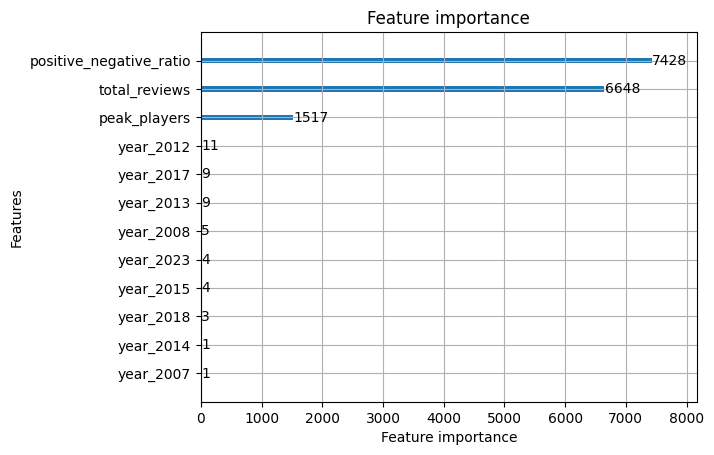

In [71]:
lightgbm.plot_importance(reg_lgbm_new)

Now try LightGBM with objective = regression l2

In [72]:
reg_lgbm_l2 = LGBMRegressor(objective = 'regression_l2', random_state =42)

In [73]:
params_7 = {
    'learning_rate': [0.1,0.01, 0.05],
    'num_leaves': [90,150,200],
    'boosting_type' : ['gbdt'],
    'max_depth' : [5,6,7,8],
    'min_split_gain' : [0.01, 0.1 ,0.05],
    'min_data_in_leaf':[10, 20, 30],
    'lambda_l2' : [0.1, 1, 10]
    }

In [74]:
rand_search7 =RandomizedSearchCV(
    reg_lgbm_l2,
    params_7,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search7.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='regression_l2',
                                           random_state=42),
                   n_jobs=10,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'lambda_l2': [0.1, 1, 10],
                                        'learning_rate': [0.1, 0.01, 0.05],
                                        'max_depth': [5, 6, 7, 8],
                                        'min_data_in_leaf': [10, 20, 30],
                                        'min_split_gain': [0.01, 0.1, 0.05],
                                        'num_leaves': [90, 150, 200]},
                   verbose=1)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

In [75]:
rand_search7.best_params_

{'num_leaves': 150,
 'min_split_gain': 0.05,
 'min_data_in_leaf': 10,
 'max_depth': 8,
 'learning_rate': 0.1,
 'lambda_l2': 10,
 'boosting_type': 'gbdt'}

In [76]:
params_8 = {
    'learning_rate': [0.1],
    'num_leaves': [140, 150, 160, 170],
    'boosting_type' : ['gbdt'],
    'max_depth' : [8, 10, 15 , 20],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10, 15, 5],
    'lambda_l2' : [5, 6, 7 , 8, 9, 10]
    }

In [77]:
rand_search8 =RandomizedSearchCV(
    reg_lgbm_l2,
    params_8,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search8.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='regression_l2',
                                           random_state=42),
                   n_jobs=10,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'lambda_l2': [5, 6, 7, 8, 9, 10],
                                        'learning_rate': [0.1],
                                        'max_depth': [8, 10, 15, 20],
                                        'min_data_in_leaf': [10, 15, 5],
                                        'min_split_gain': [0.01],
                                        'num_leaves': [140, 150, 160, 170]},
                   verbose=1)

In [78]:
rand_search8.best_params_

{'num_leaves': 160,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'max_depth': 15,
 'learning_rate': 0.1,
 'lambda_l2': 7,
 'boosting_type': 'gbdt'}

In [79]:
params_9 = {
    'learning_rate': [0.1],
    'num_leaves': [160],
    'boosting_type' : ['gbdt'],
    'max_depth' : [10,13,15, 17],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'lambda_l2' : [7]
    }

In [80]:
rand_search9 =RandomizedSearchCV(
    reg_lgbm_l2,
    params_9,
    n_jobs = 10,
    cv = 5,
    verbose=1,
)
rand_search9.fit(X_train, y_train)

/Users/wootaekkim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='regression_l2',
                                           random_state=42),
                   n_jobs=10,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'lambda_l2': [7],
                                        'learning_rate': [0.1],
                                        'max_depth': [10, 13, 15, 17],
                                        'min_data_in_leaf': [10],
                                        'min_split_gain': [0.01],
                                        'num_leaves': [160]},
                   verbose=1)

In [81]:
rand_search9.best_params_

{'num_leaves': 160,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'max_depth': 17,
 'learning_rate': 0.1,
 'lambda_l2': 7,
 'boosting_type': 'gbdt'}

In [82]:
reg_lgbm_l2_new = LGBMRegressor(objective = 'regression_l2',
                        random_state =42,
                        num_leaves = 160,
                        min_split_gain = 0.01,
                        min_data_in_leaf = 10,
                        max_depth = 17,
                        learning_rate = 0.1,
                        lambda_l2 = 7,
                        boosting_type = 'gbdt')
reg_lgbm_l2_new.fit(X_train, y_train)

LGBMRegressor(lambda_l2=7, max_depth=17, min_data_in_leaf=10,
              min_split_gain=0.01, num_leaves=160, objective='regression_l2',
              random_state=42)

In [110]:
print('Mean squared error score is:',mean_squared_error(y_test,reg_lgbm_l2_new.predict(X_test)))
print('RMSE score is : ',rmse(reg_lgbm_l2_new.predict(X_test),y_test))

Mean squared error score is: 0.01604804299460127
RMSE score is :  0.12668087067352068


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

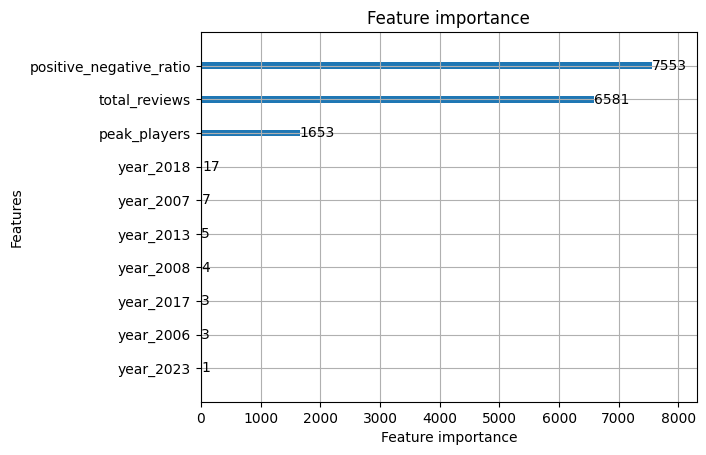

In [85]:
lightgbm.plot_importance(reg_lgbm_l2_new)

From above we can see that major feature that is most influential for splitting for all models is positive_negative ratio. This makes sense as more positive ratio means there is higher possiblity that people will give good ratings to the game. Now to get modle with better accuracy, use stacked model

### Stacked Model

In [99]:
stacked_model = StackingCVRegressor(regressors=(reg_xgb_new, reg_lgbm_new, reg_lgbm_l2_new),
                                    meta_regressor=reg_xgb_new, use_features_in_secondary=True)

In [100]:
stacked_model.fit(X_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=7, reg_l

StackingCVRegressor(meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None,
                                                feature_types=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate...
                                             nthread=4, num_parallel_tree=None,
                                             predictor=None, ...),
                                LGBMRegressor(max_depth=17, min_data_in_leaf=30,
                                              min_split_gain=0.02,
                                              num_leaves=180,
                                              objective='mean_squared_error',
                                              random_state=42),
                                LGBMRegressor(lambda_l2=7, max_depth=17,
                                              min_data_in_leaf=10,
                                              min_split_gain=0.01,
                                              num_leaves=160,
                                              objective='regression_l2',
                                              random_state=42)),
                    use_features_in_secondary=True)

In [109]:
print('Mean squared error score is:', mean_squared_error(y_test,stacked_model.predict(X_test)))
print('RMSE score is : ', rmse(stacked_model.predict(X_test),y_test))

Mean squared error score is: 0.009383932421691617
RMSE score is :  0.09687069950037326
